In [1]:
import pandas as pd
import numpy as np
import yaml
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from B_model_opti import model_optimization, plot_estimation

##### 1. Load all data that is needed

In [2]:
# Load experimental data
df_exp = pd.read_csv('data/data_combined.csv')
biomass_exp = df_exp['Biomass [g/L]']
substrate_exp = df_exp['Glucose [g/L]']

In [3]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

mu_max = param['mu_max']
X_max = param['X_max']
Ks = param['Ks']
Ks_qs = param['Ks_qs']
Ki = param['Ki']
Yxs = param['Yxs']
qs_max = param['qs_max']
m_s = param['m_s']
lag = param['lag']

##### 2. Define all possible equations for mu and qs

In [4]:
# -- MONOD / insert: mu_max, c_glucose, Ks
mu0 = lambda mu_max, c_glucose, Ks: mu_max * c_glucose / (c_glucose + Ks)
# -- LOGISTIC / insert: mu_max, c_biomass, X_max
mu1 = lambda mu_max, c_biomass, X_max: mu_max * (1 - (c_biomass/ X_max)) 
# -- MONOD + LOGISTIC / insert: mu_max, c_glucose, Ks, c_biomass, X_max
mu2 = lambda mu_max, c_glucose, Ks, c_biomass, X_max: mu_max * (c_glucose / (c_glucose + Ks)) * (1 - (c_biomass/ X_max))
# -- MONOD + LOGISTIC + INHIBITION / insert: mu_max, c_glucose, Ks, Ki, c_biomass, X_max
mu3 = lambda mu_max, c_glucose, Ks, Ki, c_biomass, X_max: mu_max * (c_glucose / (c_glucose + Ks + (c_glucose**2/ Ki))) * (1 - (c_biomass/ X_max))

In [5]:
# -- MONOD / insert: qs_max, c_glucose, Ks_qs
qs0 = lambda qs_max, c_glucose, Ks_qs: qs_max * c_glucose / (Ks_qs + c_glucose)
# -- MONOD + NON COMPETITIVE INHIBITION / insert: qs_max, c_glucose, Ks_qs, Ki, glu_met
qs1 = lambda qs_max, c_glucose, Ks_qs, Ki, glu_met: qs_max * c_glucose / (Ks_qs + c_glucose) * (Ki / (Ki + glu_met))
# -- YIELD / insert: Yxs, f_glucose, V
qs2 = lambda Yxs, f_glucose, V: 1/Yxs * f_glucose / V #NOT SURE IF CORRECT because g_S/g_X but not per h
# -- MONOD + METABOLIZED GLU / insert: qs_max, c_glucose, Ks_qs, glu_met, lag
qs3 = lambda qs_max, c_glucose, Ks_qs, glu_met, lag: qs_max * c_glucose / (Ks_qs + c_glucose) * (1 / (np.exp(glu_met * lag)))

##### 4. Define functions that are needed

In [6]:
# Root mean squared error is the objective function
def objective_function(parameters, mu_eq, num_mu, qs_eq, num_qs):
    # Solve the model using the optimal parameters
    time_pred, biomass_pred, substrate_pred = model_optimization(param, parameters, mu_eq, num_mu, qs_eq, num_qs)  # Solve the model using the current parameters
    biomass = pd.concat([biomass_exp, pd.Series(biomass_pred)], axis=1, keys=['biomass_exp', 'biomass_pred']).dropna()
    biomass_exp_ = biomass['biomass_exp'].values
    biomass_pred_ = biomass['biomass_pred'].values
    mse_x = mean_squared_error(biomass_exp_, biomass_pred_)  # Calculate mean squared error for biomass

    glucose = pd.concat([substrate_exp, pd.Series(substrate_pred)], axis=1, keys=['substrate_exp', 'substrate_pred']).dropna()
    substrate_exp_ = glucose['substrate_exp'].values
    substrate_pred_ = glucose['substrate_pred'].values
    mse_s = mean_squared_error(substrate_exp_, substrate_pred_)  # Calculate mean squared error for substrate
    mse = (mse_x + mse_s)/2
    rmse = np.sqrt(mse)  # Calculate root mean squared error
    return rmse, time_pred, biomass_pred, substrate_pred

##### 5. Run it

In [7]:
mu_all=[mu0, mu1, mu2, mu3]
qs_all=[qs0, qs1, qs2, qs3]

In [8]:
# Define number of parameter set to save it in the correct folder
set_num = 1

init_p = [mu_max, X_max, Ks, Ks_qs, Ki, Yxs, qs_max, m_s, lag]
# random bounds now -- maybe range of 30% of literature value
parameter_bounds = [(0.0,0.6), (15,30), (5,10), (5,10), (0.0,0.1), (0.0,1.0), (0.0,1.0), (0.0,0.5), (0.0,0.1)]

mu0 - qs0 - rmse: 39.211
mu0 - qs1 - rmse: 48.664
mu0 - qs2 - rmse: 439.654
mu0 - qs3 - rmse: 39.639
mu1 - qs0 - rmse: 27.45
mu1 - qs1 - rmse: 27.397
mu1 - qs2 - rmse: 13.745
mu1 - qs3 - rmse: 27.463
mu2 - qs0 - rmse: 27.061
mu2 - qs1 - rmse: 21.185
mu2 - qs2 - rmse: 13.052
mu2 - qs3 - rmse: 26.788
mu3 - qs0 - rmse: 22.114
mu3 - qs1 - rmse: 18.451
mu3 - qs2 - rmse: 13.53
mu3 - qs3 - rmse: 21.341


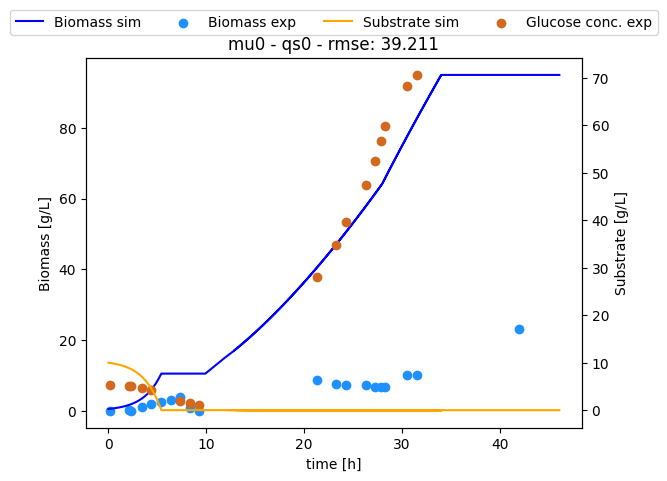

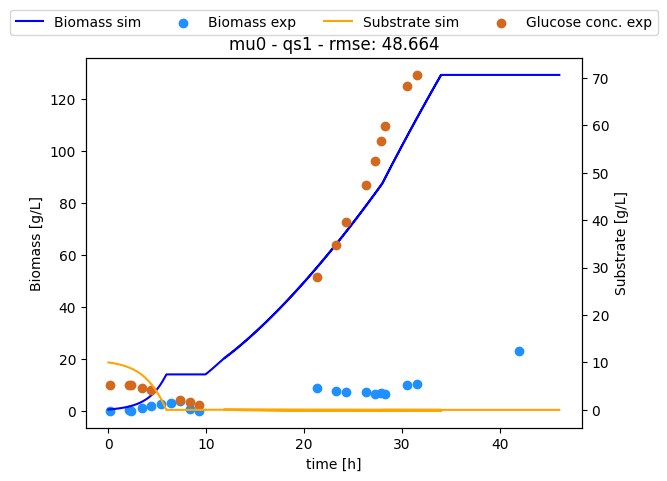

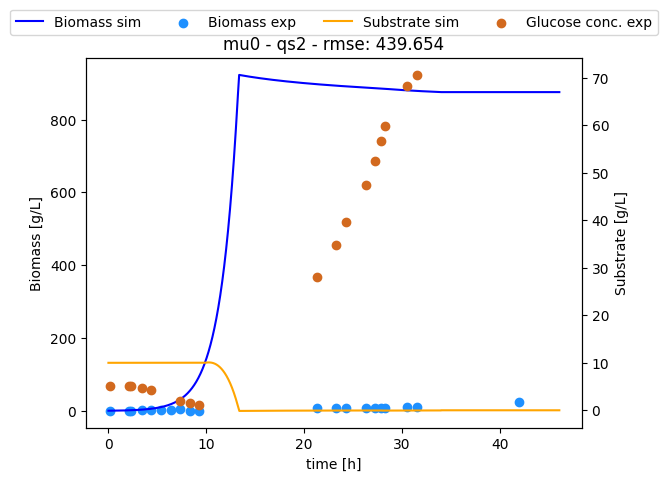

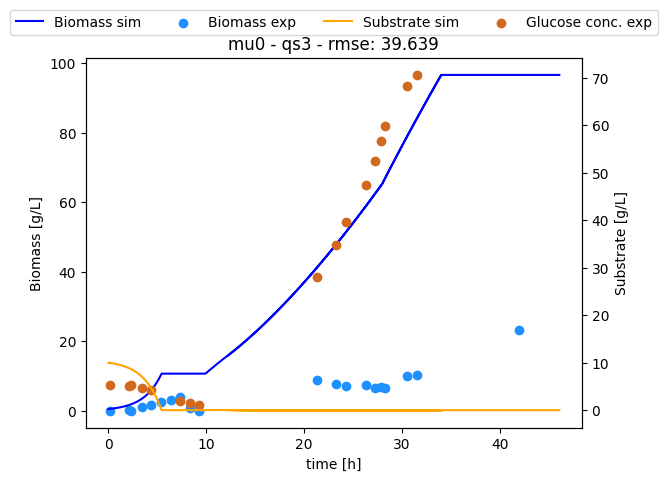

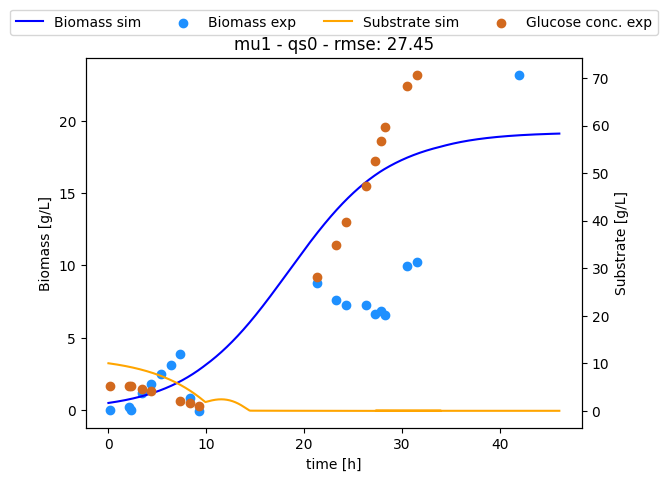

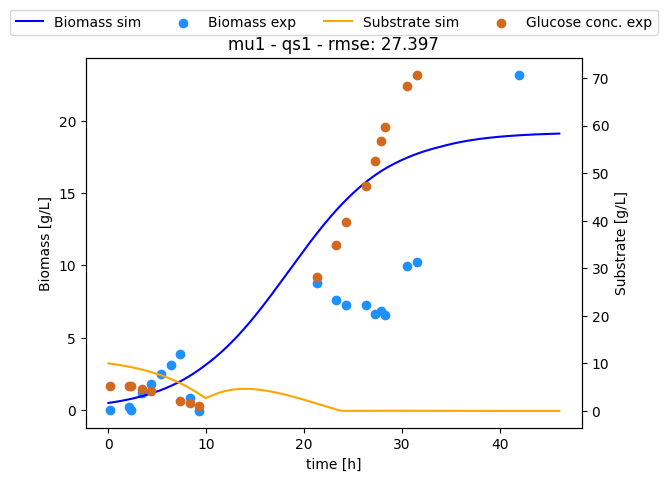

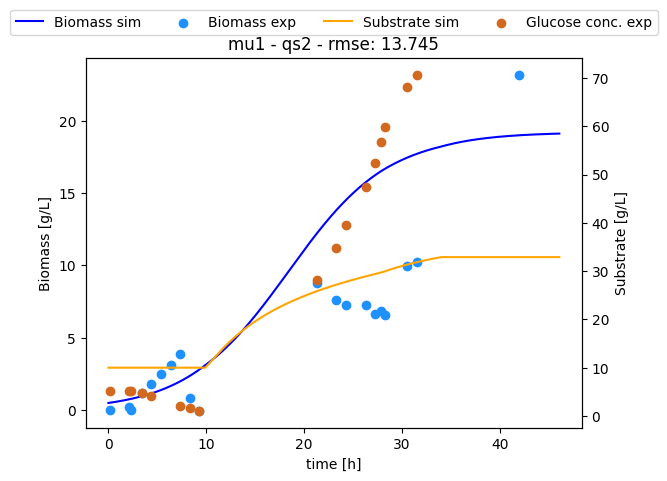

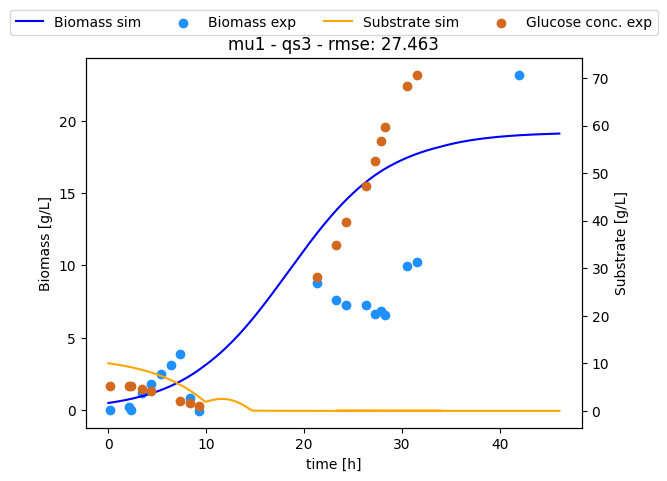

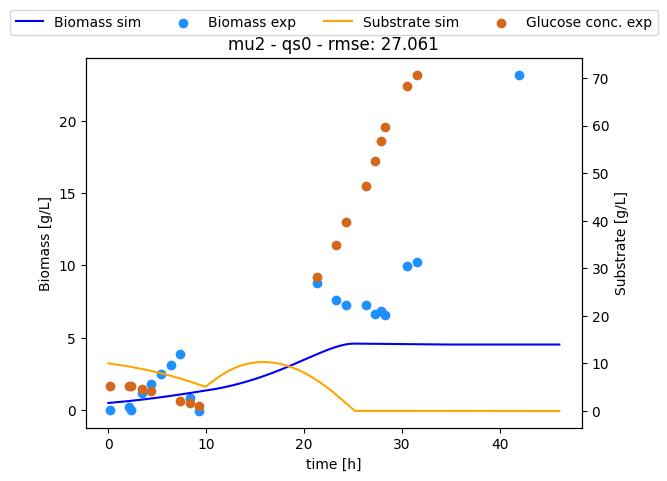

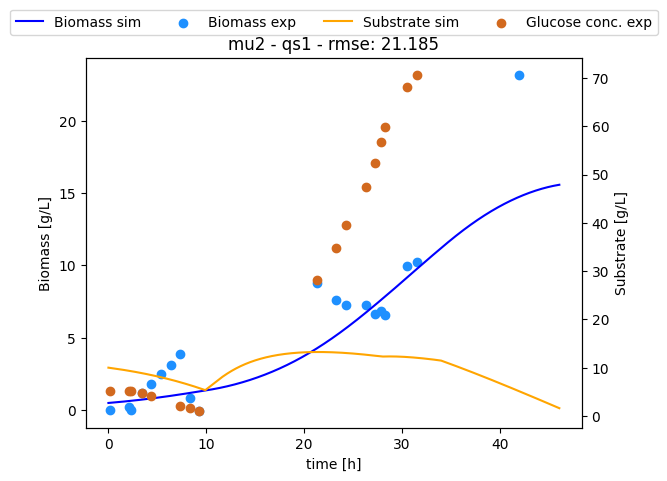

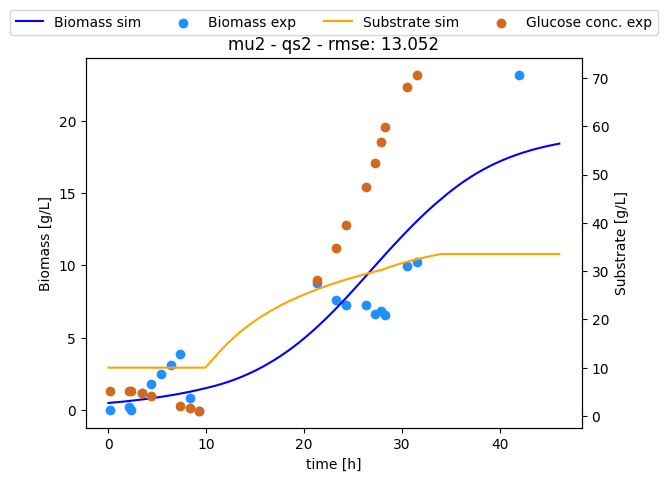

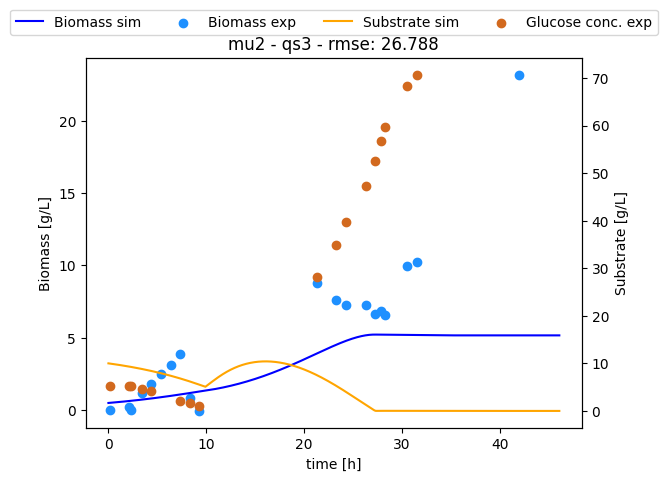

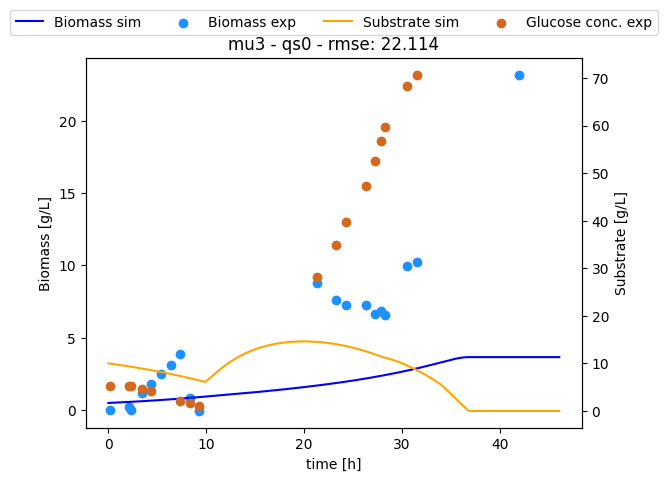

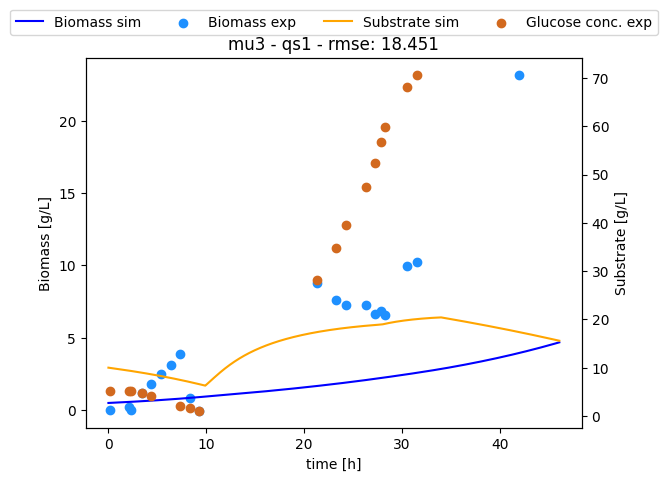

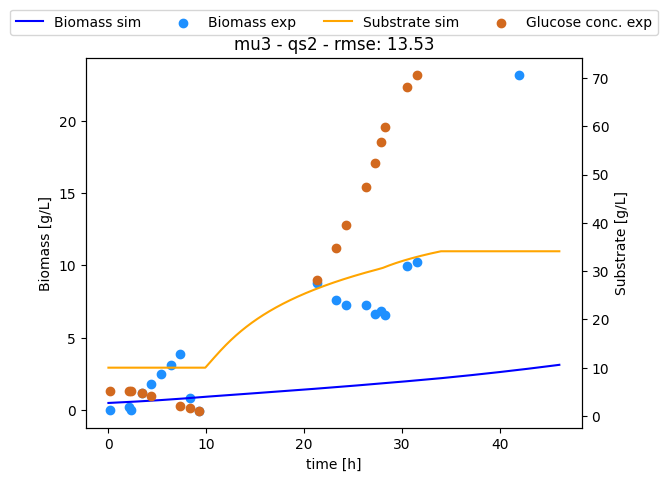

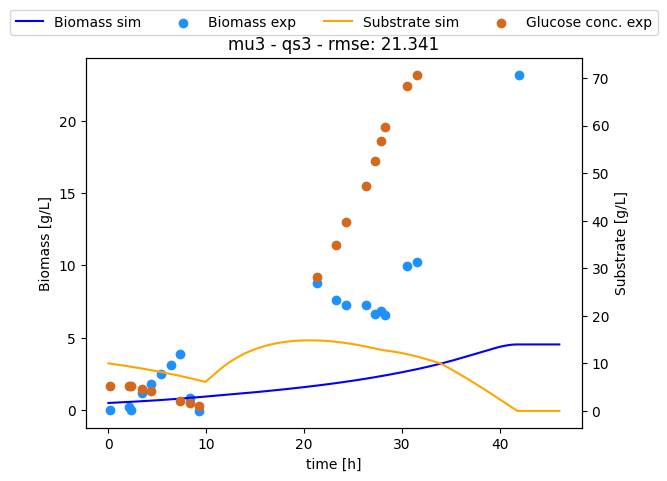

In [9]:
# Save all parameters and equations and the RMSE in a dataframe
rmse_overview = []
for i in range(len(mu_all)):
    for j in range(len(qs_all)):
        # Define the combination of equations
        mu_eq = mu_all[i]; num_mu = i
        qs_eq = qs_all[j]; num_qs = j

        # Make the predictions and calculate the error
        rmse, time_pred, biomass_pred, substrate_pred = objective_function(init_p, mu_eq, num_mu, qs_eq, num_qs)
        # save the parameters in a dataframe
        append_list=[i, j, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], init_p[6], init_p[7], init_p[8], round(rmse, 3)]
        rmse_overview.append(append_list)

        # Make a plot and save it
        title = f'mu{i} - qs{j} - rmse: {round(rmse, 3)}'
        plot_name = f'mu{i}_qs{j}'
        print(title)
        plot_estimation(time_pred, biomass_pred, substrate_pred, title, plot_name, set_num)

In [10]:
df_set = pd.DataFrame(rmse_overview, columns=['mu', 'qs', 'mu_max', 'X_max', 'Ks', 'Ks_qs', 'Ki', 'Yxs', 'qs_max', 'm_s', 'lag', 'rmse'])
df_set.to_csv('data/estimation/set1/set1.csv')
